In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import minmax_scale

### Global Variables

In [74]:
#start, end = '2020-03-06', '2021-01-27' #postings df
start, end = '2020-01-01', '2021-01-27'
start_lockdown1, start_lockdown2, start_lockdown3 = '2020-03-16', '2020-11-17', '2020-12-26'
end_lockdown1, end_lockdown2, end_lockdown3 = '2020-04-20', '2020-12-06', '2021-02-07'
input_postings = r'../data/preprocessing/combined_postings_final.pickle'
input_summer_gap = r'../data/preprocessing/year_20_final.pickle'
input_survey = r'../data/survey_data_covid_variables.csv'

### Load datasets

Load and analyize survey dataset:

In [3]:
survey = pd.read_csv(input_survey)

e:\users\moritz\dokumente\uni\ipds_standardforum\venv\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (27,30) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
survey.head()

,welle,co01,co02,co02_09,co02_01,co02_02,co02_03,co02_04,co02_05,co02_06,...,co21_04,co21_05,co21_06,co21_07,co21_08,co21_09,co21_10,co21_11,co22,co23
0,1,4,1,1,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,4,1,1,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,1,1,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,3,1,1,1,1,2,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,4,1,2,1,1,1,1,1,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
len(survey['co05_01']), len(survey[survey['co05_01'] == -9]), (survey['co05_01'].isnull().sum()), (survey['co05_01'].isna().sum())

(12029, 0, 0, 0)

In [6]:
len(survey['co19_01']), len(survey[survey['co19_01'] == -9]), (survey['co19_01'].isnull().sum()), (survey['co19_01'].isna().sum())

(12029, 0, 9018, 9018)

In [7]:
survey_sub = survey[['welle', 'co05_01', 'co06_01', 'co06_02', 'co06_03', 'co06_04', 'co06_05', 'co06_06', 'co08_01', 'co19_01']]
# co05_01: Die derzeit gültigen von der Regierung ergriffenen Maßnahmen zur Eindämmung der Covid-19 Pandemie sollten..."
#    values: 1 - 3 (=mehr maßnahmen)
# co19_01: Wie schätzen Sie Ihren Informationsstand rund um die aktuellen Verordnungen/Maßnahmen, die im Rahmen der Covid-.."
#    values: 1 - 5 (=gute kommunikation)

In [8]:
wave_map = {
    1: pd.to_datetime('5.5.2020'),
    2: pd.to_datetime('5.28.2020'),
    3: pd.to_datetime('6.17.2020'),
    4: pd.to_datetime('7.8.2020'),
    5: pd.to_datetime('7.30.2020'),
    6: pd.to_datetime('8.22.2020'),
    7: pd.to_datetime('9.14.2020'),
    8: pd.to_datetime('9.29.2020'),
    9: pd.to_datetime('10.21.2020'),
    10: pd.to_datetime('11.11.2020'),
    11: pd.to_datetime('11.28.2020'),
    12: pd.to_datetime('12.22.2020'),
}

In [9]:
survey_sub['wave_end'] = pd.to_datetime(survey_sub['welle'].map(wave_map))

<ipython-input-9-82dcc5cc7d1c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survey_sub['wave_end'] = pd.to_datetime(survey_sub['welle'].map(wave_map))


In [10]:
survey_sub = survey_sub.set_index('wave_end')
#survey_sub = survey_sub.drop(['welle'], axis=1)

Load and analyze postings dataset:

In [81]:
cols_to_drop = ['rid', 'ppid', 'o', 'hl', 'tx', 'cn', '13', '16', '17', '19', '31', '200', 'pid_liwc']
postings = pd.read_pickle(input_postings).drop(cols_to_drop, axis=1)
postings.head()

,oid,pid,cd,vp,vn,allText,18,number_tokens
0,2000122865130,1064710786,2020-12-31 20:04:57.643000+01:00,4,0,Herr Bundespräsidentnach Artikel 70 B-VG könne...,0,28
1,2000122865130,1064724063,2021-01-01 06:00:14.350000+01:00,2,0,Der Flash wird noch eine weitere Amtszeit dafü...,0,9
2,2000122865130,1064712838,2020-12-31 20:57:02.017000+01:00,2,0,Das ist wahrscheinlich sogar unserem HBP zu pe...,0,8
3,2000122865130,1064708391,2020-12-31 19:09:04.760000+01:00,3,0,Ausnahmegesetze für unseren Ausnahmenkanzler ...,0,4
4,2000122865130,1064707195,2020-12-31 18:43:57.973000+01:00,3,0,Anschober will...Anschober kann aber nicht.,0,5


In [83]:
postings.index = pd.to_datetime(postings.cd, utc=True)

In [84]:
postings['anger'] = postings['18']/postings['number_tokens']

In [32]:
postings.head()

,oid,pid,cd,vp,vn,allText,18,number_tokens,anger
cd,,,,,,,,,
2020-12-31 19:04:57.643000+00:00,2000122865130,1064710786,2020-12-31 20:04:57.643000+01:00,4,0,Herr Bundespräsidentnach Artikel 70 B-VG könne...,0,28,0.0
2021-01-01 05:00:14.350000+00:00,2000122865130,1064724063,2021-01-01 06:00:14.350000+01:00,2,0,Der Flash wird noch eine weitere Amtszeit dafü...,0,9,0.0
2020-12-31 19:57:02.017000+00:00,2000122865130,1064712838,2020-12-31 20:57:02.017000+01:00,2,0,Das ist wahrscheinlich sogar unserem HBP zu pe...,0,8,0.0
2020-12-31 18:09:04.760000+00:00,2000122865130,1064708391,2020-12-31 19:09:04.760000+01:00,3,0,Ausnahmegesetze für unseren Ausnahmenkanzler ...,0,4,0.0
2020-12-31 17:43:57.973000+00:00,2000122865130,1064707195,2020-12-31 18:43:57.973000+01:00,3,0,Anschober will...Anschober kann aber nicht.,0,5,0.0


<AxesSubplot:>

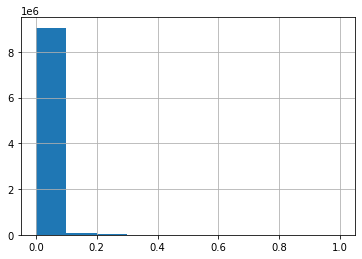

In [33]:
postings['anger'].hist()

In [85]:
postings_summer_gap = pd.read_pickle(input_summer_gap).sort_index()
postings_summer_gap.index = pd.to_datetime(postings_summer_gap.index, utc=True)
postings_summer_gap.tail()

,postid,parentid,communityidentityid,communityname,timestamp,followers,ratings_pos,ratings_neg,fullText,13,16,17,18,19,31,200,number_tokens
timestamp,,,,,,,,,,,,,,,,,
2021-01-11 21:13:29+00:00,1065338274,1.064871e+09,748531.0,ThomasSV,1610399609,0.0,0,0,Sehe ich nicht... Wenn man das in einen TV Spl...,1,0,0,0,0,1,0,51
2021-01-11 21:18:30+00:00,1065338499,1.064888e+09,748531.0,ThomasSV,1610399910,0.0,0,0,"Es steht Ihnen frei, Politiker zu werden und a...",2,1,0,0,0,2,0,24
2021-01-11 21:22:40+00:00,1065338708,1.064853e+09,748531.0,ThomasSV,1610400160,0.0,0,0,Die Lösung ist schon lange bekannt ;)https://w...,0,0,0,0,0,0,0,7
2021-01-11 21:35:02+00:00,1065339290,1.063851e+09,567219.0,lupos,1610400902,1.0,0,0,"Konsum von Alkohol in Liter 2016RUS: 20,1 AUT:...",0,0,0,0,0,0,0,10
2021-01-11 22:50:27+00:00,1065342095,1.065338e+09,209091.0,StefVienna,1610405427,8.0,0,0,"Sie bestreiten also generell, daß hier ordentl...",0,1,0,1,0,2,0,19


In [94]:
postings_summer_gap['anger2'] = postings_summer_gap['18'] / postings_summer_gap['number_tokens']

In [66]:
p1 = pd.DataFrame(postings['anger'])
p1.index = postings['pid']

p2 = pd.DataFrame(postings_summer_gap['anger'])
p2.index = postings_summer_gap['postid']
print(p1.shape)
print(p2.shape)

(9214323, 1)
(1366347, 1)


In [72]:
pd.Series(list(set(postings['pid']) & set(postings_summer_gap['postid'])))

<ipython-input-72-fa5ea95781e2>:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pd.Series(list(set(postings['pid']) & set(postings_summer_gap['postid'])))


Series([], dtype: float64)

In [96]:
combined = pd.concat([postings['anger'].resample('1d').sum(), postings_summer_gap['anger2'].resample('1d').sum()], axis=1)
combined['anger_total'] = combined['anger'].fillna(0) + combined['anger2'].fillna(0)

In [97]:
combined

,anger,anger2,anger_total
2020-01-20 00:00:00+00:00,NaN,0.809049,0.809049
2020-01-21 00:00:00+00:00,NaN,0.278864,0.278864
2020-01-22 00:00:00+00:00,NaN,0.074917,0.074917
2020-01-23 00:00:00+00:00,NaN,0.944649,0.944649
2020-01-24 00:00:00+00:00,NaN,1.288482,1.288482
...,...,...,...
2021-01-23 00:00:00+00:00,125.033905,NaN,125.033905
2021-01-24 00:00:00+00:00,124.058009,NaN,124.058009
2021-01-25 00:00:00+00:00,2.858739,NaN,2.858739
2021-01-26 00:00:00+00:00,0.000000,NaN,0.000000


In [18]:
survey_grouped = survey_sub.groupby('welle').resample('1d').mean()
survey_grouped.index = survey_grouped.index.droplevel('welle')
survey_grouped['baseline_diff_05'] = (survey_grouped['co05_01'] - survey_grouped['co05_01'][0])/survey_grouped['co05_01'][0]
survey_grouped['baseline_diff_06_1'] = (survey_grouped['co06_01'] - survey_grouped['co06_01'][0])/survey_grouped['co06_01'][0]
survey_grouped['baseline_diff_06_2'] = (survey_grouped['co06_02'] - survey_grouped['co06_02'][0])/survey_grouped['co06_02'][0]
survey_grouped['baseline_diff_06_3'] = (survey_grouped['co06_03'] - survey_grouped['co06_03'][0])/survey_grouped['co06_03'][0]
survey_grouped['baseline_diff_06_4'] = (survey_grouped['co06_04'] - survey_grouped['co06_04'][0])/survey_grouped['co06_04'][0]
survey_grouped['baseline_diff_06_5'] = (survey_grouped['co06_05'] - survey_grouped['co06_05'][0])/survey_grouped['co06_05'][0]
survey_grouped['baseline_diff_06_6'] = (survey_grouped['co06_06'] - survey_grouped['co06_06'][0])/survey_grouped['co06_06'][0]
survey_grouped['baseline_diff_08'] = (survey_grouped['co08_01'] - survey_grouped['co08_01'][0])/survey_grouped['co08_01'][0]
survey_grouped['baseline_diff_19'] = (survey_grouped['co19_01'] - survey_grouped['co19_01'][9])/survey_grouped['co19_01'][9]
survey_grouped

,welle,co05_01,co06_01,co06_02,co06_03,co06_04,co06_05,co06_06,co08_01,co19_01,baseline_diff_05,baseline_diff_06_1,baseline_diff_06_2,baseline_diff_06_3,baseline_diff_06_4,baseline_diff_06_5,baseline_diff_06_6,baseline_diff_08,baseline_diff_19
wave_end,,,,,,,,,,,,,,,,,,,
2020-05-05,1.0,1.639361,2.182817,1.422577,0.564436,2.892108,2.083916,2.154845,2.535465,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
2020-05-28,2.0,1.612935,1.900498,1.254726,0.735323,2.503483,2.010945,1.963184,2.532338,NaN,-0.016119,-0.129337,-0.117991,0.302759,-0.134374,-0.035016,-0.088944,-0.001233,NaN
2020-06-17,3.0,1.617383,1.651349,1.199800,0.615385,2.144855,1.996004,1.879121,2.480519,NaN,-0.013406,-0.243478,-0.156601,0.090265,-0.258377,-0.042186,-0.127955,-0.021671,NaN
2020-07-08,4.0,2.043000,1.475000,1.064000,0.488000,1.916000,1.864000,1.628000,2.410000,NaN,0.246218,-0.324268,-0.252062,-0.135419,-0.337507,-0.105530,-0.244493,-0.049484,NaN
2020-07-30,5.0,2.285000,1.442000,1.057000,0.344000,1.871000,1.811000,1.709000,2.358000,NaN,0.393836,-0.339386,-0.256982,-0.390542,-0.353067,-0.130963,-0.206904,-0.069993,NaN
2020-08-22,6.0,2.093812,1.503992,1.081836,0.394212,1.885230,1.860279,1.838323,2.337325,NaN,0.277213,-0.310986,-0.239524,-0.301583,-0.348147,-0.107316,-0.146888,-0.078147,NaN
2020-09-14,7.0,2.126747,1.421158,1.055888,0.408184,1.867265,1.892216,1.811377,2.393214,NaN,0.297302,-0.348934,-0.257764,-0.276829,-0.354358,-0.091991,-0.159393,-0.056104,NaN
2020-09-29,8.0,2.158000,1.553000,1.109000,0.426000,2.028000,1.897000,1.822000,2.486000,NaN,0.316367,-0.288534,-0.220429,-0.245264,-0.298781,-0.089695,-0.154464,-0.019509,NaN
2020-10-21,9.0,2.120159,1.614697,1.092354,0.390268,2.077458,2.006951,1.811321,2.602781,NaN,0.293284,-0.260269,-0.232131,-0.308569,-0.281680,-0.036933,-0.159420,0.026550,NaN


<AxesSubplot:xlabel='wave_end'>

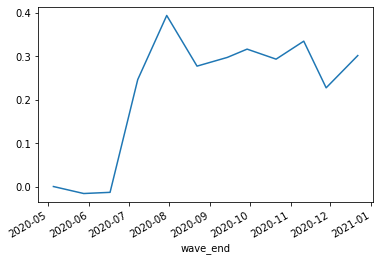

In [19]:
survey_grouped['baseline_diff_05'].plot()

### Plots

<ipython-input-124-c43cd93ae3ed>:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(lables)


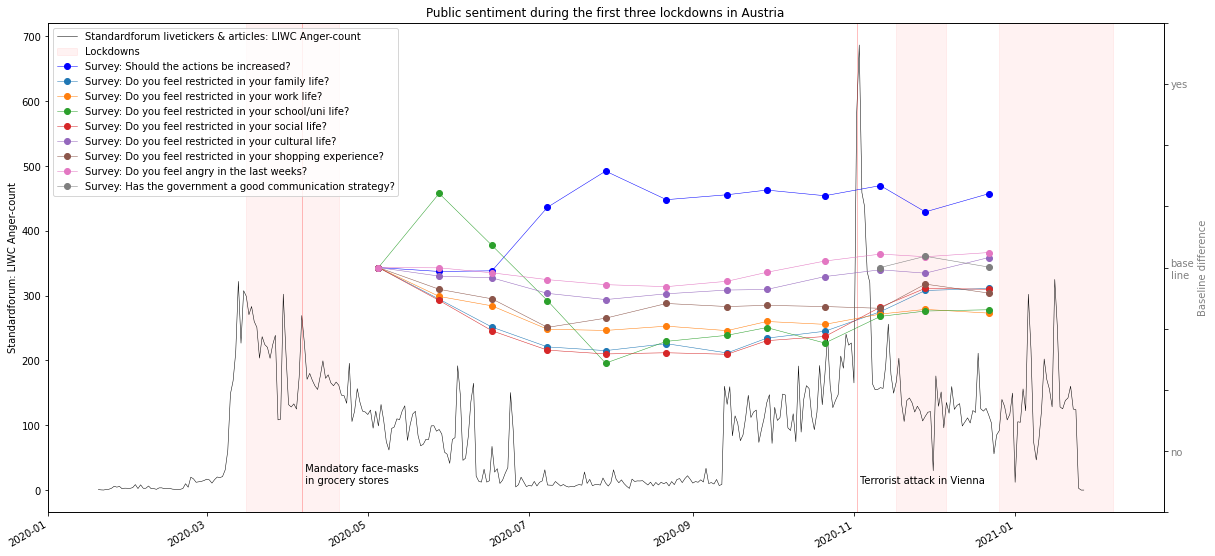

In [124]:
fig, ax = plt.subplots(figsize=(20,10))
#ax.plot(postings.resample('1d').sum().loc[start:end, 'anger'], linestyle='-', linewidth=0.5, label='Standardforum: Anger from livetickers', color='black')
#ax.plot(postings_summer_gap.resample('1d').sum().loc[start:end, 'anger'], linestyle='-', linewidth=0.5, label='Standardforum: Anger from articles', color='red')
ax.plot(combined.loc[start:end, 'anger_total'], linestyle='-', linewidth=0.5, label='Standardforum livetickers & articles: LIWC Anger-count', color='black')

ax.set_ylabel('Standardforum: LIWC Anger-count')

ax.axvspan(pd.to_datetime(start_lockdown1), pd.to_datetime(end_lockdown1), color='red', alpha=0.05, label="Lockdowns")
ax.axvspan(pd.to_datetime(start_lockdown2), pd.to_datetime(end_lockdown2), color='red', alpha=0.05)
ax.axvspan(pd.to_datetime(start_lockdown3), pd.to_datetime(end_lockdown3), color='red', alpha=0.05)

ax.axvline(pd.to_datetime('2020-04-06'), linewidth=0.5, color='red', alpha=0.5)
ax.text(x=pd.to_datetime('2020-04-06'), y=10, s=' Mandatory face-masks\n in grocery stores', rotation=0)
ax.axvline(pd.to_datetime('2020-11-02'), linewidth=0.5, color='red', alpha=0.5)
ax.text(x=pd.to_datetime('2020-11-02'), y=10, s=' Terrorist attack in Vienna', rotation=0)

ax2 = ax.twinx()
ax2.set_ylim([-1,1])
lables = [item.get_text() for item in ax2.get_yticklabels()]
lables[1] = 'no'
lables[len(lables)-2] = 'yes'
lables[int(len(lables)/2)] = 'base\nline'
ax2.set_yticklabels(lables)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_05'],label="Survey: Should the actions be increased?", linestyle='-', marker='o', linewidth=0.5, color='blue')
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_06_1'],label="Survey: Do you feel restricted in your family life?", linestyle='-', marker='o', linewidth=0.5)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_06_2'],label="Survey: Do you feel restricted in your work life?", linestyle='-', marker='o', linewidth=0.5)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_06_3'],label="Survey: Do you feel restricted in your school/uni life?", linestyle='-', marker='o', linewidth=0.5)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_06_4'],label="Survey: Do you feel restricted in your social life?", linestyle='-', marker='o', linewidth=0.5)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_06_5'],label="Survey: Do you feel restricted in your cultural life?", linestyle='-', marker='o', linewidth=0.5)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_06_6'],label="Survey: Do you feel restricted in your shopping experience?", linestyle='-', marker='o', linewidth=0.5)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_08'],label="Survey: Do you feel angry in the last weeks?", linestyle='-', marker='o', linewidth=0.5)
ax2.plot(survey_grouped.index, survey_grouped['baseline_diff_19'],label="Survey: Has the government a good communication strategy?", linestyle='-', marker='o', linewidth=0.5)

ax2.tick_params(axis='y', labelcolor='gray')

fig.autofmt_xdate()
ax2.set_ylabel("Baseline difference", color='gray')
ax.set_title("Public sentiment during the first three lockdowns in Austria")

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc=0)